# Testing different norms

Will use the optimal architecture from ex d)

### Imports

In [50]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import importlib, prepare_data, neural_network
importlib.reload(prepare_data)
importlib.reload(neural_network)

# --- Our own code ---
from neural_network import NeuralNetwork
from optimizers import SGD, RMSprop, Adam
from losses import mse, mse_deriv
from activations import sigmoid, sigmoid_deriv, linear, linear_deriv, relu, relu_deriv, leaky_relu, leaky_relu_deriv
from prepare_data import prepare_data


### Prepare data

In [51]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

scaler_x = StandardScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_test_s = scaler_x.transform(x_test)
x_s = scaler_x.transform(x)

## L2 regularization

MSE on test data:
Lambda=0.0, MSE = 1.9561668417288353e-06
Lambda=1e-06, MSE = 1.387105440668007e-05
Lambda=1e-05, MSE = 2.936544777016712e-06
Lambda=0.0001, MSE = 4.641284224841252e-06
Lambda=0.001, MSE = 4.8815815561185655e-05
Lambda=0.01, MSE = 0.0001667541082317682
Lambda=0.1, MSE = 0.07262463544392425


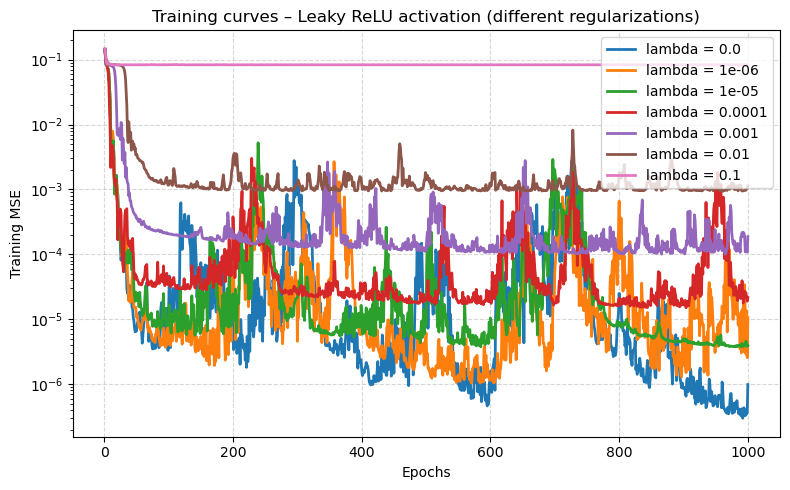

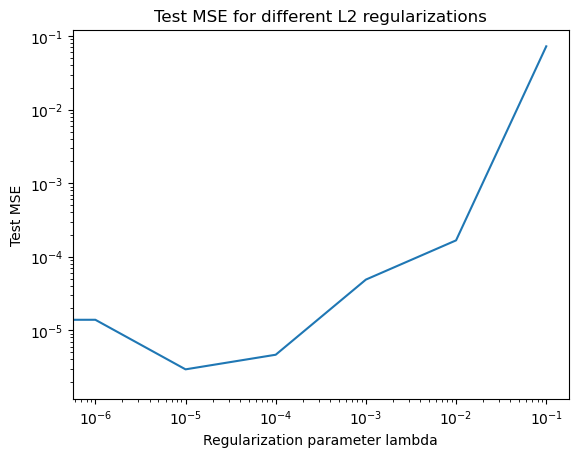

In [52]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lambdas = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr = 1e-2
epochs = 1000
batch_size = 32

# Empty lists
histories = []
MSEs = []

for lam in lambdas:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l2_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data:")
for i in range(len(lambdas)):
    print(f"Lambda={lambdas[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, lam in zip(histories, lambdas):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"lambda = {lam}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training MSE")
plt.title("Training curves – Leaky ReLU activation (different regularizations)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(lambdas, MSEs)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Regularization parameter lambda")
plt.ylabel("Test MSE")
plt.title("Test MSE for different L2 regularizations")
plt.show()
    


We see that the best regularization (excluding lam=0.0) is 1e-5. Will use this when comparing with Ridge regression from project 1

### Comparing with Ridge

In [53]:
from Code_Project1.polynomial_features import polynomial_features
from Code_Project1.Ridge import Ridge_parameters

MSEs: 
Ridge regression MSE = 0.0018463473610311719
Neural Network MSE = 2.936544777016712e-06


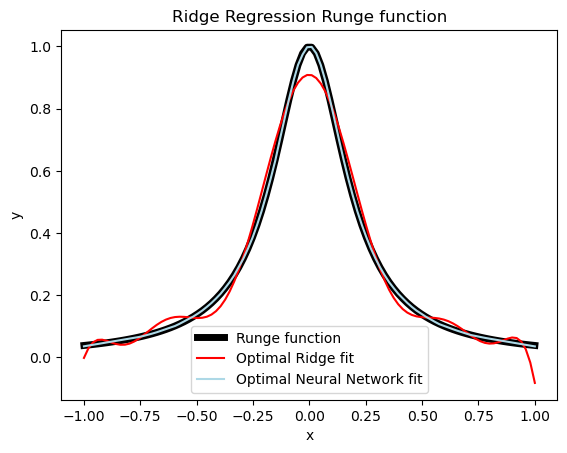

In [54]:
### Ridge Regression with optimal parameters ###
pol=13
lam=1e-5

X_train = polynomial_features(x_train.ravel(),pol, False)
X_test = polynomial_features(x_test.ravel(), pol, False)
X_plot = polynomial_features(x.ravel(), pol, False)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
X_plot_s  = scaler.transform(X_plot)
y_offset = np.mean(y_train)

beta = Ridge_parameters(X_train_s, y_train, lambda_=lam)
y_pred_full_Ridge = X_plot_s@beta + y_offset
y_pred_test_Ridge = X_test_s@beta + y_offset
MSE_Ridge = mse(y_pred_test_Ridge, y_test)

### Neural network with optimal paramters ###
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-5
lr = 1e-2
epochs = 1000
batch_size = 32
nn = NeuralNetwork(network_input_size=1,
                    layer_output_sizes=layers,
                    activation_funcs=activations,
                    activation_ders=activation_ders,
                    cost_fun=mse,
                    cost_der=mse_deriv,
                    seed=seed,
                    l2_lambda=lam)
optimizer = Adam(lr=lr)
history = nn.fit(x_train_s,
                    y_train,
                    epochs = epochs,
                    batch_size=batch_size,
                    optimizer = optimizer,
                    log_every=None)
y_pred_full_nn = nn.predict(x_s)
y_pred_test_nn = nn.predict(x_test_s)
MSE_nn = mse(y_pred_test_nn, y_test)

### Printing MSEs ###
print("MSEs: ")
print(f"Ridge regression MSE = {MSE_Ridge}")
print(f"Neural Network MSE = {MSE_nn}")

### Plotting Fits ###
plt.plot(x, y, color="black", linewidth=5, label="Runge function")
plt.plot(x, y_pred_full_Ridge, color="red",label="Optimal Ridge fit")
plt.plot(x, y_pred_full_nn, color="lightblue",label="Optimal Neural Network fit")
plt.title("Ridge Regression Runge function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()




## Analyzing L1 regularization

MSE on test data: (L1 regularization)
Lambda=0.0, MSE = 1.8871721470121746e-06
Lambda=1e-06, MSE = 9.72564798111117e-06
Lambda=1e-05, MSE = 8.908538294682207e-06
Lambda=0.0001, MSE = 4.590909917495044e-06
Lambda=0.001, MSE = 3.826095146132825e-05
Lambda=0.01, MSE = 0.07236189579339353
Lambda=0.1, MSE = 0.07216762222350527


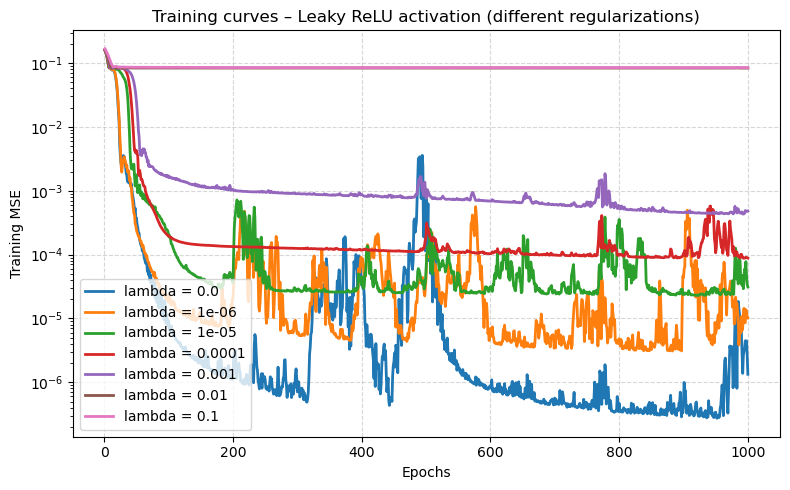

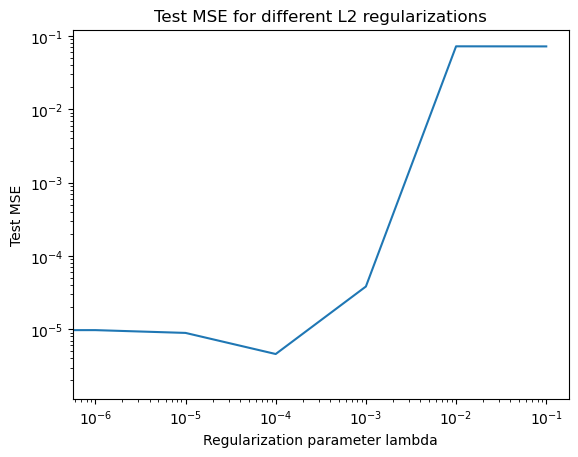

In [55]:
# Parameters for neural network and training
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lambdas = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr = 5e-3
epochs = 1000
batch_size = 50

# Empty lists
histories = []
MSEs = []

for lam in lambdas:
    nn = NeuralNetwork(network_input_size=1,
                       layer_output_sizes=layers,
                       activation_funcs=activations,
                       activation_ders=activation_ders,
                       cost_fun=mse,
                       cost_der=mse_deriv,
                       seed=seed,
                       l1_lambda=lam)
    optimizer = Adam(lr=lr)
    history = nn.fit(x_train_s,
                     y_train,
                     epochs = epochs,
                     batch_size=batch_size,
                     optimizer = optimizer,
                     log_every=None)
    histories.append(history["train_loss"])
    y_test_pred = nn.predict(x_test_s)
    mse_test = mse(y_test_pred, y_test)
    MSEs.append(mse_test)

print("MSE on test data: (L1 regularization)")
for i in range(len(lambdas)):
    print(f"Lambda={lambdas[i]}, MSE = {MSEs[i]}")
    
### Plotting training curves ###

plt.figure(figsize=(8,5))
for losses, lam in zip(histories, lambdas):
    epochs = np.arange(1, len(losses)+1)
    plt.plot(epochs, losses, label=f"lambda = {lam}", linewidth=2)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Training MSE")
plt.title("Training curves – Leaky ReLU activation (different regularizations)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

plt.plot(lambdas, MSEs)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Regularization parameter lambda")
plt.ylabel("Test MSE")
plt.title("Test MSE for different L2 regularizations")
plt.show()
    


Optimal L1 regularization (excluding no regularization) is 1e-4, will compare this with LASSO regression. Optimal batch size = 50, optimal learning rate = 5e-3

### Comparing with LASSO regression

The optimal paramters for LASSO from project 1 was lam = 1e-5 and deg = 10, which we found by using Scikit learn. For reproducibility, we will use scikit learn again when comparing LASSO with our neural network with L1 regularization.

In [56]:
from sklearn.linear_model import Lasso

MSEs: 
LASSO regression MSE = 0.14930231012849074
Neural Network MSE = 4.590909917495044e-06


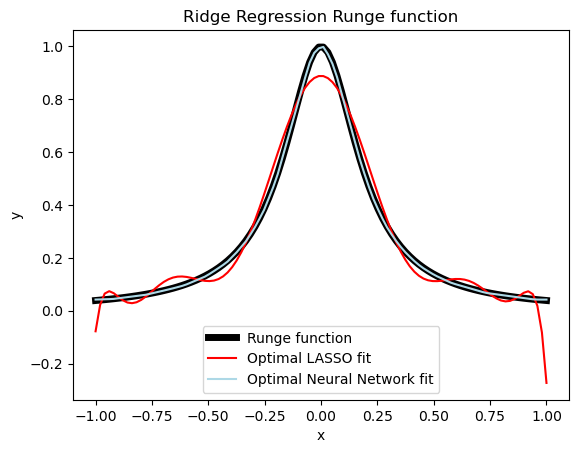

In [58]:
### Optimal LASSO regression ###
deg = 10
lam = 1e-5

X_train = polynomial_features(x_train.ravel(),pol, False)
X_test = polynomial_features(x_test.ravel(), pol, False)
X_plot = polynomial_features(x.ravel(), pol, False)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
X_plot_s  = scaler.transform(X_plot)
y_offset = np.mean(y_train)

lasso = Lasso(alpha=lam, fit_intercept=False, max_iter=10000000)
lasso.fit(X_train_s, y_train)
beta_sklearn = lasso.coef_
y_pred_full_LASSO = X_plot_s@beta_sklearn + y_offset
y_pred_test_LASSO = X_test_s@beta_sklearn + y_offset
MSE_LASSO = mse(y_pred_test_LASSO, y_test)

### Neural network with optimal parameters ###
layers = [32, 32, 32, 1]
activations = [leaky_relu, leaky_relu, leaky_relu, linear]
activation_ders = [leaky_relu_deriv, leaky_relu_deriv, leaky_relu_deriv, linear_deriv]
lam = 1e-4
lr = 5e-3
epochs = 1000
batch_size = 50
nn = NeuralNetwork(network_input_size=1,
                    layer_output_sizes=layers,
                    activation_funcs=activations,
                    activation_ders=activation_ders,
                    cost_fun=mse,
                    cost_der=mse_deriv,
                    seed=seed,
                    l1_lambda=lam)
optimizer = Adam(lr=lr)
history = nn.fit(x_train_s,
                    y_train,
                    epochs = epochs,
                    batch_size=batch_size,
                    optimizer = optimizer,
                    log_every=None)
y_pred_full_nn = nn.predict(x_s)
y_pred_test_nn = nn.predict(x_test_s)
MSE_nn = mse(y_pred_test_nn, y_test)

### Printing MSEs ###
print("MSEs: ")
print(f"LASSO regression MSE = {MSE_LASSO}")
print(f"Neural Network MSE = {MSE_nn}")

### Plotting Fits ###
plt.plot(x, y, color="black", linewidth=5, label="Runge function")
plt.plot(x, y_pred_full_LASSO, color="red",label="Optimal LASSO fit")
plt.plot(x, y_pred_full_nn, color="lightblue",label="Optimal Neural Network fit")
plt.title("Ridge Regression Runge function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


